#Treinamento de Modelo de CLassificação de imagem

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

#Como usar o dataset do Tensorflow: https://www.tensorflow.org/datasets/overview?hl=pt-br
#Datasets do Tensorflow: https://www.tensorflow.org/datasets/catalog/overview?hl=pt-br

##Importando o dataset de imagens

O dataset [*Cats vs Dogs*](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs?hl=pt-br) está disponível diretamente no módulo `tensorflow_datasets (tfds)`.
Ele contém cerca de 25000 imagens de gatos e cachorros, divididas em uma única partição `train`.

Usamos o parâmetro `as_supervised=True` para obter pares `(image, label)` e `with_info=True` para inspecionar mais informações do dataset.

In [ ]:
dataset, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True)
train_ds = dataset['train']

##Visualização Inicial dos dados

In [ ]:
print("Nome do dataset:", info.name)
print("Número de classes:", info.features['label'].num_classes)
print("Nomes das classes:", info.features['label'].names)
print("Splits disponíveis:", list(info.splits.keys()))

Nome do dataset: cats_vs_dogs
Número de classes: 2
Nomes das classes: ['cat', 'dog']
Splits disponíveis: ['train']


Notamos que o dataset só tem uma split disponível, chamada `(train)` logo será necessário dividir as imagens, tomando cuidado com o balanceamento de quantidade das classes.
Extraindo mais informações de informações de`(train)`:

In [ ]:
print("Total de imagens em 'train':", info.splits['train'].num_examples)
print("Formato das imagens:", info.features['image'].shape)
print("Tipo das imagens:", info.features['image'].np_dtype)

Total de imagens em 'train': 23262
Formato das imagens: (None, None, 3)
Tipo das imagens: <class 'numpy.uint8'>


O dataset possui, ao todo, 23262 imagens RGB de tamanhos diferentes (evidenciado por 'None, None, 3'). Além disso, o tipo `(uint8)` indica que seus pixels assumem valores entre 0 e 255, ou seja, não foram normalizados. Com isso em mente, temos alguns problemas a serem tratados:

- Redimensionar ou fazer um Padding das imagens.
- Normalizar os pixels.
- Fazer a separação manualmente entre os dados de treino e de teste.

##Visualização rápida de algumas imagens de `(train)`

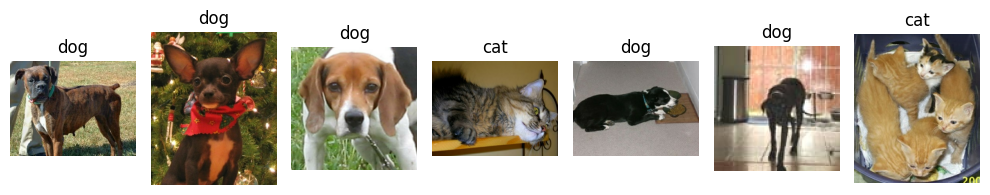

In [ ]:
class_names = info.features['label'].names

plt.figure(figsize=(10, 5))
for i, (image, label) in enumerate(dataset['train'].take(7)):
    plt.subplot(1, 7, i + 1)
    plt.imshow(image)
    plt.title(class_names[label])
    plt.axis("off")
plt.tight_layout()
plt.show()

Notavelmente, o dataset não está organizado em ordem alfabética, o que é um ponto positivo.
Caso as imagens estivessem dispostas dessa forma (por exemplo, todos os gatos seguidos de todos os cachorros), seria necessário aplicar um tratamento adicional para embaralhar e redistribuir os dados, evitando um possível viés na divisão entre treino e validação.
A ausência dessa ordenação facilita o pré-processamento e contribui para uma distribuição mais equilibrada e representativa das classes.

Visualização aleatória de 5 imagens do dataset:

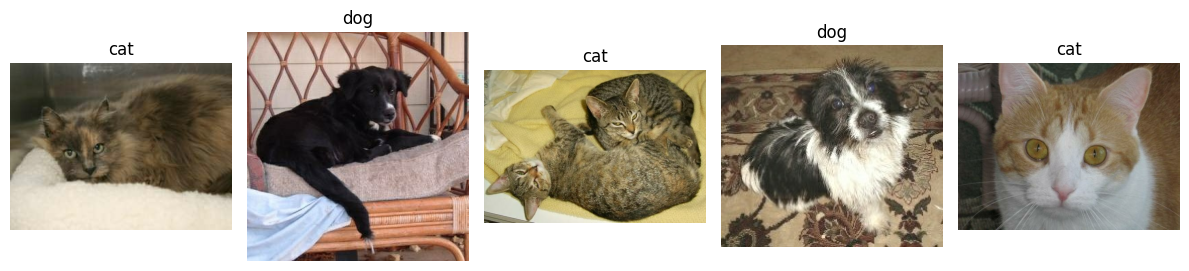

In [ ]:
class_names = info.features['label'].names

plt.figure(figsize=(12,4))
for i, (image, label) in enumerate(dataset['train'].shuffle(1000, seed=43).take(5)):
    plt.subplot(1,5,i+1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(class_names[int(label.numpy())])
    plt.axis('off')
plt.tight_layout()
plt.show()

##Processamento dos dados

Como visto na etapa anterior, por enquanto não vamos nos preocupar com questão de distribuição das categorias. Vamos tratar de outros tratamentos especiais dos dados primeiro.

# Função de Pré-processamento

Esta função aplica padding e normalização nas imagens:
- **Padding**: Redimensiona mantendo proporção e adiciona bordas pretas
- **Normalização**: Converte pixels de [0, 255] para [0, 1]


    **Args:**
        image: Tensor da imagem original
        label: Label da imagem (0=cat, 1=dog)
        
    
    **Returns:**
        image_processed: Imagem processada
        label: Label original

### Padding

In [ ]:
image_width = 180
image_height = 180
AUTO = tf.data.AUTOTUNE

image_color_channels = 3
image_color_channel_size = 255

image_size = (image_width, image_height)
image_shape = image_size + (image_color_channels,)

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
], name="data_augmentation")

In [ ]:
def preprocess_image(image, label, training=False):
  # Redimensionar com padding (mantém aspect ratio)
  # Adiciona bordas pretas se necessário
  image = tf.image.resize_with_pad(
      image,
      target_height=image_height,
      target_width=image_width
  )

  if training:
    image = data_augmentation(image, training=True)

  # Normalizar pixels: [0, 255] → [0, 1]
  # Divisão por 255.0 converte para float e normaliza
  image = image / 255.0

  return image, label

### Visualizando Preprocessing

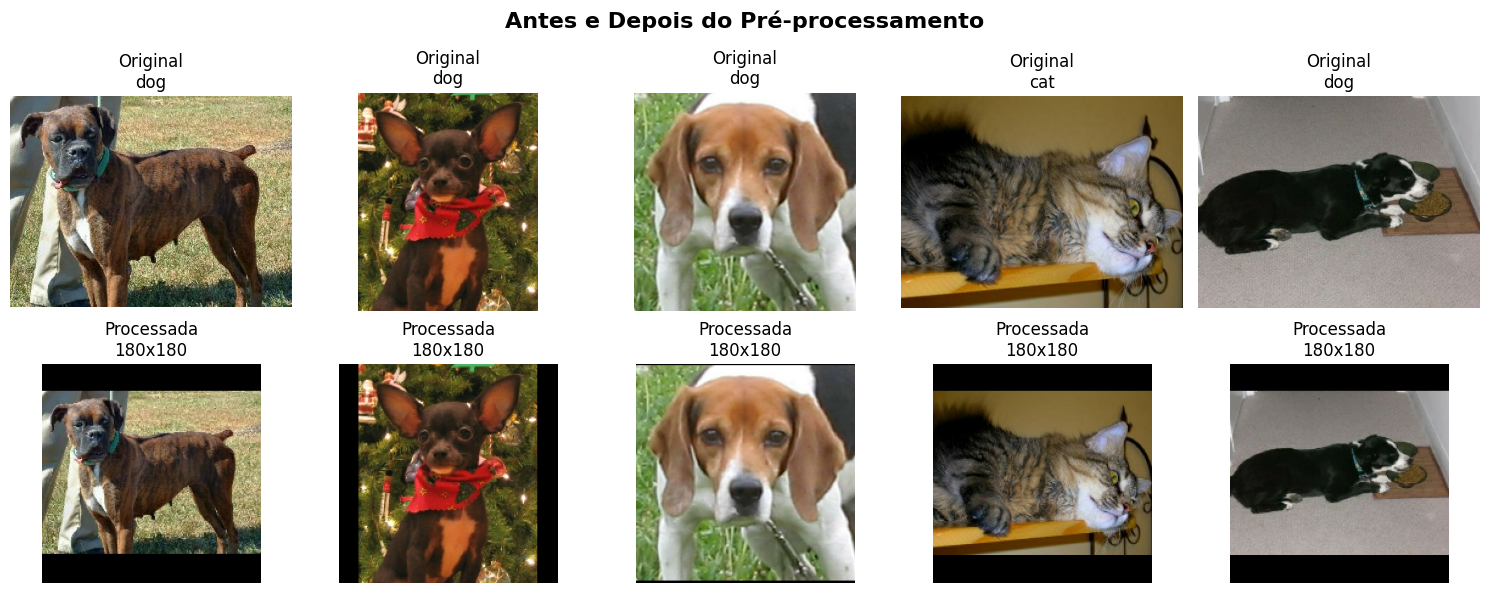

In [ ]:
# Pegar algumas imagens para demonstração
sample_ds = train_ds.take(5)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Antes e Depois do Pré-processamento', fontsize=16, fontweight='bold')

for i, (image, label) in enumerate(sample_ds):
    # Imagem original
    axes[0, i].imshow(image)
    axes[0, i].set_title(f'Original\n{class_names[label]}')
    axes[0, i].axis('off')

    # Imagem processada
    processed_img, _ = preprocess_image(image, label)
    axes[1, i].imshow(processed_img)
    axes[1, i].set_title(f'Processada\n{image_width}x{image_height}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

## Separação train e validation

In [ ]:
total_images = info.splits['train'].num_examples
print(f"Total de imagens: {total_images}")

train_size = int(0.8 * total_images)
val_size = total_images - train_size

print(f"\nDivisão dos dados:")
print(f"  Treino: {train_size} imagens ({train_size/total_images*100:.1f}%)")
print(f"  Validação: {val_size} imagens ({val_size/total_images*100:.1f}%)")

Total de imagens: 23262

Divisão dos dados:
  Treino: 18609 imagens (80.0%)
  Validação: 4653 imagens (20.0%)


##Criação do Modelo

In [ ]:
bath_size = 16 # quantidade de features por vez do meu dataset
epochs = 16 # quantidade de vezes que vou passar pelo dataset
learning_rate = 0.0001

dataset_shuffled = dataset['train'].shuffle(500, seed=42)

train_ds = dataset_shuffled.take(train_size)
train_ds = train_ds.map(lambda x, y: preprocess_image(x, y, training=True),
                        num_parallel_calls=AUTO)
train_ds = train_ds.batch(bath_size).prefetch(AUTO)

val_ds = dataset_shuffled.skip(train_size)
val_ds = val_ds.map(preprocess_image, num_parallel_calls=AUTO)
val_ds = val_ds.batch(bath_size).prefetch(AUTO)

In [ ]:
model = tf.keras.models.Sequential([
	  tf.keras.layers.Conv2D(32, (3,3), activation="relu", padding="same",
                  input_shape=(image_width, image_height, 3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same"),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation="relu", padding="same"),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation="relu", padding="same"),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy']
)

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 22, 22, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,982,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,223,553 (8.48 MB)

 Trainable params: 2,223,553 (8.48 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs,
)

Epoch 1/16
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 1578s 1s/step - accuracy: 0.5604 - loss: 0.6733 - val_accuracy: 0.6392 - val_loss: 0.6334
Epoch 2/16
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 1591s 1s/step - accuracy: 0.6998 - loss: 0.5775 - val_accuracy: 0.7621 - val_loss: 0.5000
Epoch 3/16
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 1581s 1s/step - accuracy: 0.7356 - loss: 0.5273 - val_accuracy: 0.7930 - val_loss: 0.4461
Epoch 4/16
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 1562s 1s/step - accuracy: 0.7739 - loss: 0.4799 - val_accuracy: 0.8208 - val_loss: 0.3991
Epoch 5/16
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 1580s 1s/step - accuracy: 0.7849 - loss: 0.4505 - val_accuracy: 0.8246 - val_loss: 0.3958
Epoch 6/16
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 1583s 1s/step - accuracy: 0.8119 - loss: 0.4172 - val_accuracy: 0.8448 - val_loss: 0.3690
Epoch 7/16
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 1564s 1s/step - accuracy: 0.8237 - loss: 0.3915 - val_accuracy: 0.8410 - val_loss: 0.3537
Epoch 8/16
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 1576s 1s/step - accuracy: 0.8290 -

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

model.save('/content/drive/MyDrive/Cats_Vs_Dogs_(data_aug).h5')

Mounted at /content/drive


In [ ]:
def plot_model():

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.gcf().clear()
    plt.figure(figsize = (15, 8))

    plt.subplot(1, 2, 1)
    plt.title('Training and Validation Accuracy')
    plt.plot(epochs_range, accuracy, label = 'Training Accuracy')
    plt.plot(epochs_range, val_accuracy, label = 'Validation Accuracy')
    plt.legend(loc = 'lower right')

    plt.subplot(1, 2, 2)
    plt.title('Training and Validation Loss')
    plt.plot(epochs_range, loss, label = 'Training Loss')
    plt.plot(epochs_range, val_loss, label = 'Validation Loss')
    plt.legend(loc = 'lower right')

    plt.show()

<Figure size 640x480 with 0 Axes>

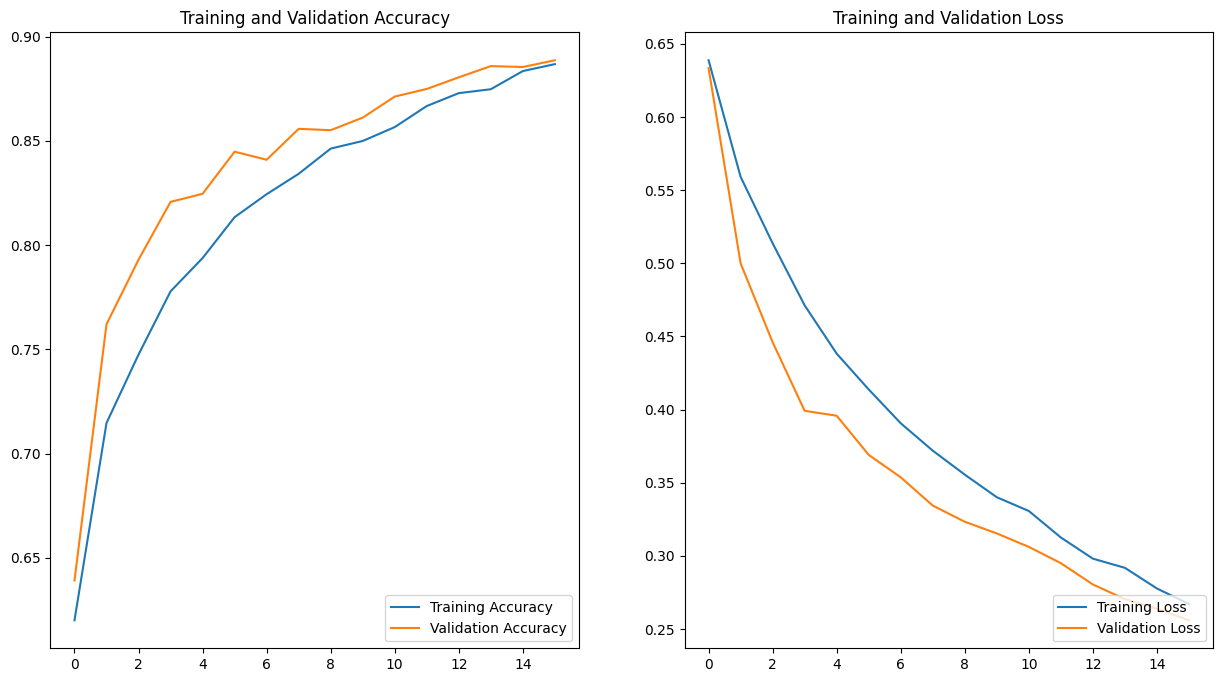

In [ ]:
plot_model()

###Separação dos dados